In [76]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier as KN
from collections import Counter
from matplotlib import pylab
from xgboost import XGBClassifier
from xgboost import plot_importance

# Загрузка данных

In [2]:
df_test = pd.read_csv("contest_test.csv", sep=',')
df_train = pd.read_csv("contest_train.csv", sep=',')

# Предобработка данных

В данных много признаков, у которых большая часть значений nan, поэтому удалим эти признаки, остальные пустые значения заменим мерой центральной тенденции

In [3]:
def drop_columns_with_nan(df1, df2, bound):
    
    counters_null = np.array(df1.isna().sum())
    columns = np.array(df1.columns)
    for number_null, column in zip(counters_null, columns):
        if number_null > bound*len(df1):
            df1 = df1.drop(column, axis=1)
            df2 = df2.drop(column, axis=1)
    return df1, df2  

def fillna(df):
    counters_null = np.array(df.isna().sum())
    columns = np.array(df.columns)
    for number_null, column in zip(counters_null, columns):
        if number_null:
            df[column].fillna(np.mean(df[column]), inplace=True)
            
def drop_columns_with_zero(df1, df2, bound):
    zeros = []
    columns = np.array(df1.columns)
    for column in columns:
        if column == 'TARGET':
            continue
        a = np.array(df_test[column])
        if np.count_nonzero(a) < bound*len(df1):
            df1 = df1.drop(column, axis=1)
            df2 = df2.drop(column, axis=1)
    return df1, df2
    
            
df_train, df_test = drop_columns_with_nan(df_train, df_test, 0.5)
fillna(df_train)
fillna(df_test)
df_train, df_test = drop_columns_with_zero(df_train, df_test, 0.1)

In [6]:
df_train.describe()

,ID,TARGET,FEATURE_0,FEATURE_1,FEATURE_7,FEATURE_8,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,...,FEATURE_248,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_257,FEATURE_258,FEATURE_259
count,2.452100e+04,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,...,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.000000,24521.00000,24521.000000
mean,1.393464e+09,0.352677,5.438196,1.337833,80.762084,278.787390,0.202439,259.315808,5.335264,2.194486,...,12.047959,41.057379,36.403205,307.827071,408.052350,0.611965,0.640390,1.138575,1.18580,1.184699
std,1.981725e+09,0.592092,14.533334,1.826413,256.605853,1177.974402,0.401826,488.882216,18.819880,2.297629,...,34.038422,105.000146,105.872566,259.669681,349.968987,0.487312,0.479896,0.373638,0.40809,0.401288
min,1.428335e+07,0.000000,0.000000,0.000000,-171.709797,-297.065679,0.000000,-311.402288,0.000000,0.000000,...,0.000000,-1256.000000,-667.000000,-1531.063435,-328.361649,0.000000,0.000000,1.000000,0.00000,1.000000
25%,4.503249e+08,0.000000,0.000000,0.000000,-9.809139,-19.140528,0.000000,0.422395,1.000000,1.000000,...,0.000000,0.000000,0.000000,129.829124,179.694989,0.000000,0.000000,1.000000,1.00000,1.000000
50%,7.449749e+08,0.000000,1.000000,1.000000,3.673798,6.508163,0.000000,48.652298,2.000000,2.000000,...,1.000000,6.000000,0.000000,265.472906,326.928038,1.000000,1.000000,1.000000,1.00000,1.000000
75%,1.152479e+09,1.000000,5.000000,2.000000,27.367809,47.143287,0.000000,278.307663,4.000000,3.000000,...,10.000000,39.000000,10.000000,408.197249,533.731611,1.000000,1.000000,1.000000,1.00000,1.000000
max,1.043892e+10,2.000000,385.000000,39.000000,3147.341440,9963.242114,1.000000,7251.231109,938.000000,24.000000,...,1483.000000,1775.000000,3194.000000,4202.905396,4440.534979,1.000000,1.000000,3.000000,3.00000,3.000000


# Подготовка обучающей выборки и ответов

нормализация векторов признаков и их считывание

In [23]:
def normalization(X):
    features = X.columns
    for feature in features:
        X[feature] = (X[feature] - X[feature].min()) / (X[feature].max() - X[feature].min())
    return X

Y_train = np.array(df_train['TARGET'])
x_test_file = df_test.drop(['ID'], axis=1)
x_test_file = normalization(x_test_file)
x_test_file = np.array(x_test_file.iloc[:])
X_train = df_train.drop(['ID', 'TARGET'], axis=1)
X_train = normalization(X_train)
std_for_features = X_train.describe().loc['std']
X_train = np.array(X_train.iloc[:])

Наши данные несбалансированны, что приводит к низкому качеству модели, надо сбалансирвать наши данные
Первый подход был просто игнорировать часть данных, но этот подход не хорошего качества
Второй подход вычислить веса для каждого класса, он тоже не принес желаемых результатов
Третий подход oversampling с помощью SMOTE этот подход показал наиулучшее качество

In [25]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train, Y_train)

In [33]:
print(sorted(Counter(y_resampled).items()))

[(0, 17372), (1, 17372), (2, 17372)]


разбиение наших данных на обучающую и тестовую выборку 

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=27, stratify=y_resampled)

# Визуализация данных

Построим диаграмму рассеивания «номер признака» — «стандартное отклонение» и посмотрим какие группы признаков у нас есть

Text(0, 0.5, 'cтандартное отклонение')

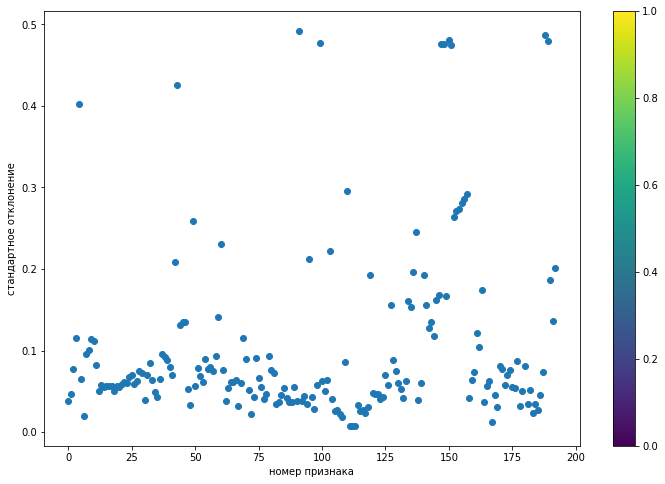

In [28]:
plt.figure(figsize = (12, 8))
plt.scatter(range(len(std_for_features)), std_for_features)
plt.colorbar()
plt.xlabel('номер признака')
plt.ylabel('cтандартное отклонение')

для визулизации данных воспользуемся моделью t-sne 

In [29]:
tsne = TSNE(n_components=2 , init = 'pca', random_state=0)
data_tsne = tsne.fit_transform(X_train)

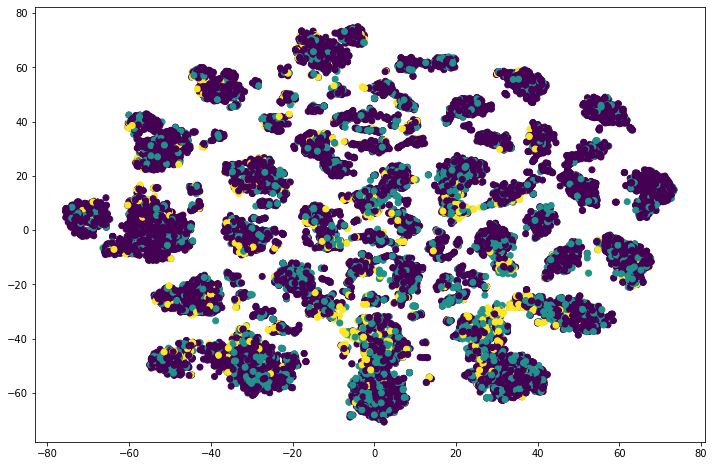

In [31]:
pylab.figure(figsize = (12, 8))
pylab.scatter(data_tsne[:, 0], data_tsne[:, 1], c = Y_train)

заметно что данные имею сложную структуру

# Построение и обучение модели

Использовал два классификатора кnn и xgboost, выше качество показал xgboost

In [36]:
classifier_knn = KN(n_neighbors=1)
classifier_knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=1)

оценка качества

In [37]:
y_pred = classifier_knn.predict(x_test)
print(f1_score(y_test, y_pred, average='macro'))

0.8178086279588014


In [39]:
eval_set = [(x_test, y_test)]
classifier_xgb = XGBClassifier(eta=0.8, max_depth=8)
classifier_xgb.fit(x_train, y_train, early_stopping_rounds=10, eval_set=eval_set)

[0]	validation_0-merror:0.29797
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.26564
[2]	validation_0-merror:0.23763
[3]	validation_0-merror:0.22448
[4]	validation_0-merror:0.21335
[5]	validation_0-merror:0.20635
[6]	validation_0-merror:0.20050
[7]	validation_0-merror:0.19676
[8]	validation_0-merror:0.19091
[9]	validation_0-merror:0.18937
[10]	validation_0-merror:0.18342
[11]	validation_0-merror:0.17968
[12]	validation_0-merror:0.17776
[13]	validation_0-merror:0.17431
[14]	validation_0-merror:0.17066
[15]	validation_0-merror:0.16664
[16]	validation_0-merror:0.16625
[17]	validation_0-merror:0.16347
[18]	validation_0-merror:0.16145
[19]	validation_0-merror:0.16040
[20]	validation_0-merror:0.15848
[21]	validation_0-merror:0.16049
[22]	validation_0-merror:0.15723
[23]	validation_0-merror:0.15484
[24]	validation_0-merror:0.15292
[25]	validation_0-merror:0.15282
[26]	validation_0-merror:0.14994
[27]	validation_0-merror:0.14822
[28]	validation_0-m

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.8, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.800000012, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

оценка качества xgboost

проведем кросс-валидацию

In [40]:
scores = cross_val_score(classifier_xgb, x_train, y_train, cv=5)

In [41]:
scores

array([0.86725027, 0.86772994, 0.86159751, 0.8699928 , 0.86435596])

In [44]:
y_pred =  classifier_xgb.predict(x_test)

In [45]:
print(f1_score(y_test, y_pred, average='macro'))

0.8705049420062231


In [82]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      3475
           1       0.90      0.74      0.81      3474
           2       0.96      0.97      0.96      3475

    accuracy                           0.87     10424
   macro avg       0.88      0.87      0.87     10424
weighted avg       0.88      0.87      0.87     10424



In [68]:
classifier_xgb.save_model("models/classifier_model")

Text(0.5, 15.0, 'Predicted class')

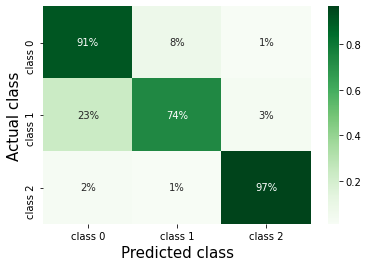

In [47]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
categories = ["class 0", "class 1", "class 2"]
sns.heatmap(cm, annot=True, fmt='.0%', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.ylabel('Actual class', fontsize=15)
plt.xlabel('Predicted class', fontsize=15)

# Выделение абонентов
Определим абонентов имеющих максимальные вероятности отношенияк сегменту 2 и 3

In [59]:
y_pred_test = classifier_xgb.predict(x_test_file)

формирование файла contest_answer.csv

In [61]:
contest_answer = pd.DataFrame(df_test['ID'])
contest_answer['TARGET'] = y_pred_test
contest_answer.to_csv('contest_answer.csv', index=False)

формирование файла contest_segments.csv

In [54]:
segment_1 = contest_answer[contest_answer['TARGET'] == 1]
segment_2 = contest_answer[contest_answer['TARGET'] == 2]

In [55]:
y_probability_test = classifier_xgb.predict_proba(x_test_file)

In [56]:
segment_1_probability = []
segment_2_probability = []
for abonent in y_probability_test:
    segment = np.where(abonent == abonent.max())[0][0]
    if segment == 1:
        segment_1_probability.append(abonent[1])
    elif segment == 2:
        segment_2_probability.append(abonent[2])

In [57]:
segment_1['probability'] = segment_1_probability
segment_2['probability'] = segment_2_probability

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [62]:
segment_1 = segment_1.sort_values(by='probability', ascending=False)
segment_1 = segment_1.iloc[0:500]
segment_2 = segment_2.sort_values(by='probability', ascending=False)
segment_2 = segment_2.iloc[0:200]
contest_segments = pd.concat([segment_1, segment_2])

In [63]:
contest_segments

,ID,TARGET,probability
3406,528572837,1,0.999977
4390,577071302,1,0.999961
185,88183164,1,0.999937
5586,1154145788,1,0.999903
5336,1153815769,1,0.999867
...,...,...,...
3114,10124013267,2,0.913791
1366,1063142787,2,0.913703
6089,89635188,2,0.913657
5477,363752842,2,0.912748


In [64]:
contest_segments = contest_segments.drop(['probability'], axis=1)
contest_segments.to_csv('contest_segments.csv', index=False)

Построим визулизацию предсказанных нами данных

In [65]:
tsne = TSNE(n_components=2 , init = 'pca', random_state=0)
data_tsne_test = tsne.fit_transform(x_test_file)

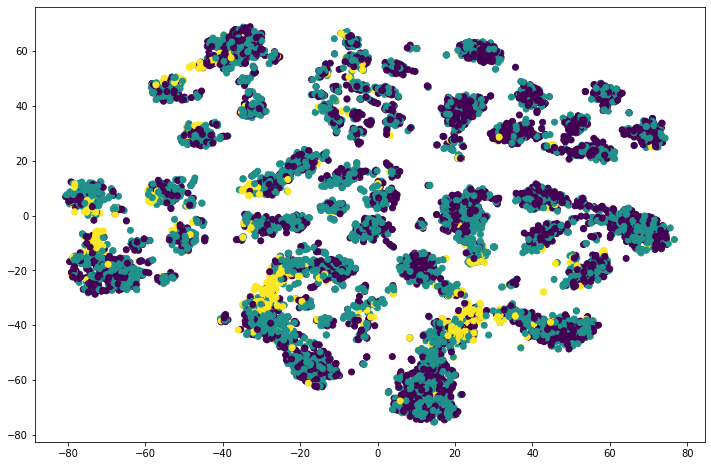

In [70]:
pylab.figure(figsize = (12, 8))
pylab.scatter(data_tsne_test[:, 0], data_tsne_test[:, 1], c = y_pred_test)